### Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

### Определение классов и функций

In [2]:
def imshow(images, labels):
    images = images / 2 + 0.5
    np_images = images.numpy()

    num_images = len(images)

    cols = 4 if num_images >= 4 else num_images
    rows = (num_images + cols - 1) // cols

    if num_images == 1:
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(np.transpose(np_images[0], (1, 2, 0)))
        ax.set_title(CLASSES[labels[0]])
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        axes = axes.flatten()

        for i in range(num_images):
            ax = axes[i]
            ax.imshow(np.transpose(np_images[i], (1, 2, 0)))
            ax.set_title(CLASSES[labels[i]])
            ax.set_xlabel("Width")
            ax.set_ylabel("Height")

        for i in range(num_images, len(axes)):
            fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


def convolutional_block(in_channels: int,
                        out_channels: int,
                        kernel_size: int,
                        padding: int) -> nn.Sequential:
    conv_block = nn.Sequential(
        nn.Conv2d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=kernel_size,
                  padding=padding),
        nn.BatchNorm2d(num_features=out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    return conv_block


class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv_block1 = convolutional_block(3, 64, 3, 1)
        self.conv_block2 = convolutional_block(64, 128, 3, 1)
        self.conv_block3 = convolutional_block(128, 256, 3, 1)
        self.conv_block4 = convolutional_block(256, 512, 3, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x

### Проверка данных

100%|██████████| 170M/170M [00:03<00:00, 44.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Размерность батча изображений: torch.Size([4, 3, 32, 32])


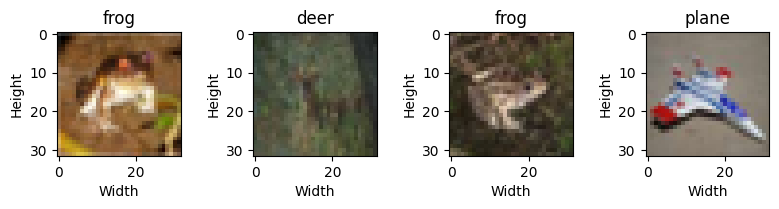

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
indices = [0, 10, 22, 30]  # or None

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

if indices is not None:
    subset = torch.utils.data.Subset(trainset, indices)
    trainloader = DataLoader(subset,
                             batch_size=batch_size,
                             shuffle=False)
else:
    trainloader = DataLoader(trainset,
                             batch_size=batch_size,
                             shuffle=True, num_workers=2)

dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f"Размерность батча изображений: {images.size()}")

imshow(images, labels)

### Инициализация модели и гиперпараметров

In [4]:
model = ConvNN().to(device)

learning_rate = 0.001
num_epochs = 10  # 10
batch_size = 32

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Загрузка данных для обучения и оценки модели

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Обучение модели

In [6]:
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    train_loss = 0.0
    num_correct_preds = 0
    total_samples = 0
    desc = f"Epoch {epoch+1}/{num_epochs}"
    with tqdm(trainloader, desc=desc, unit="batch") as batch_bar:
        for i, data in enumerate(batch_bar):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)

            num_correct_preds += (predicted == labels).sum().item()

            accuracy = num_correct_preds / total_samples

            batch_bar.set_postfix({
                'loss': loss.item(),
                'accuracy': f'{100. * accuracy:.2f}%'
            })

    epoch_loss = train_loss / len(trainloader)
    epoch_accuracy = 100 * num_correct_preds / total_samples

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_accuracy:.2f}%')

print('Training completed!')

Epoch 1/10: 100%|██████████| 1563/1563 [00:37<00:00, 42.15batch/s, loss=1.02, accuracy=55.08%]


Epoch 1, Loss: 1.253, Accuracy: 55.08%


Epoch 2/10: 100%|██████████| 1563/1563 [00:29<00:00, 53.31batch/s, loss=0.555, accuracy=69.30%]


Epoch 2, Loss: 0.872, Accuracy: 69.30%


Epoch 3/10: 100%|██████████| 1563/1563 [00:27<00:00, 56.78batch/s, loss=0.813, accuracy=75.63%]


Epoch 3, Loss: 0.707, Accuracy: 75.63%


Epoch 4/10: 100%|██████████| 1563/1563 [00:26<00:00, 58.83batch/s, loss=0.53, accuracy=79.85%]


Epoch 4, Loss: 0.589, Accuracy: 79.85%


Epoch 5/10: 100%|██████████| 1563/1563 [00:26<00:00, 58.29batch/s, loss=0.992, accuracy=83.05%]


Epoch 5, Loss: 0.489, Accuracy: 83.05%


Epoch 6/10: 100%|██████████| 1563/1563 [00:26<00:00, 58.48batch/s, loss=0.64, accuracy=85.88%]


Epoch 6, Loss: 0.411, Accuracy: 85.88%


Epoch 7/10: 100%|██████████| 1563/1563 [00:26<00:00, 58.55batch/s, loss=0.44, accuracy=88.38%]


Epoch 7, Loss: 0.333, Accuracy: 88.38%


Epoch 8/10: 100%|██████████| 1563/1563 [00:26<00:00, 58.54batch/s, loss=0.131, accuracy=90.34%]


Epoch 8, Loss: 0.274, Accuracy: 90.34%


Epoch 9/10: 100%|██████████| 1563/1563 [00:26<00:00, 59.00batch/s, loss=0.0353, accuracy=92.20%]


Epoch 9, Loss: 0.223, Accuracy: 92.20%


Epoch 10/10: 100%|██████████| 1563/1563 [00:27<00:00, 56.34batch/s, loss=0.242, accuracy=93.42%]

Epoch 10, Loss: 0.187, Accuracy: 93.42%
Training completed!


### Оценка модели

In [7]:
num_correct_preds = 0
total_samples = 0
test_loss = 0.0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)

        num_correct_preds += (predicted == labels).sum().item()

test_loss = test_loss / len(testloader)
test_accuracy = 100 * num_correct_preds / total_samples
print(f"Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.2f}%")

Loss: 0.687, Accuracy: 81.05%


### Построение графиков ошибки и точности на обучении

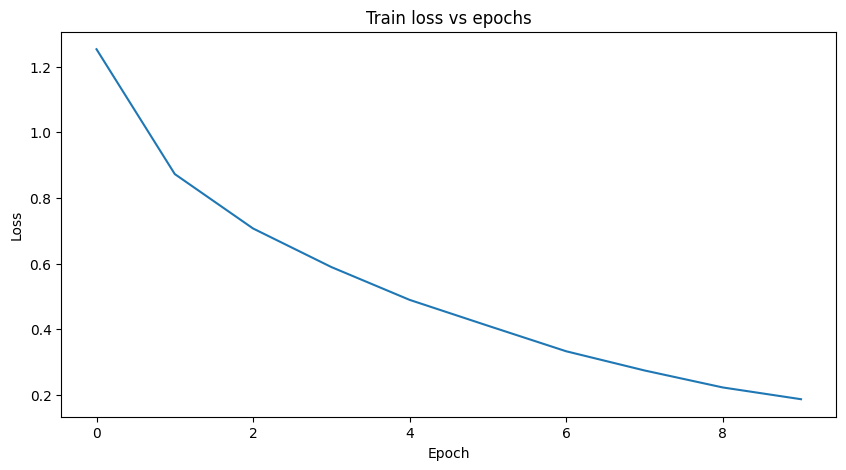

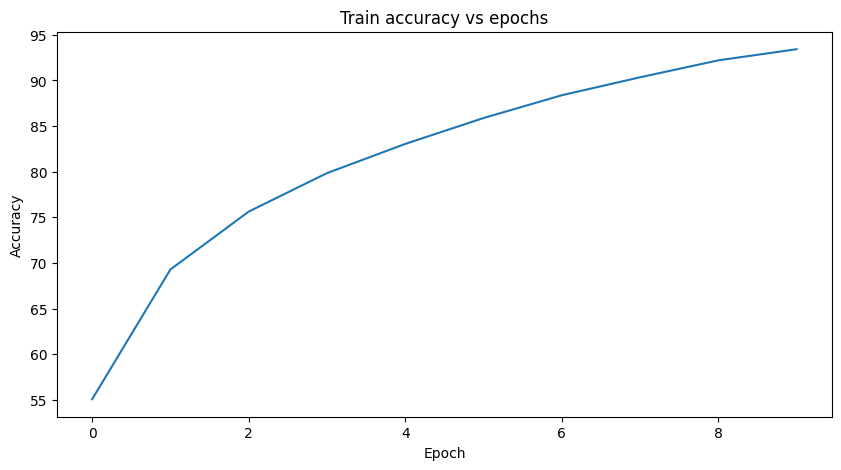

In [8]:
def plot_curve(data, title, label):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.plot(data, label=label)
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.show()

plot_curve(train_losses, "Train loss vs epochs", "Loss")
plot_curve(train_accuracies, "Train accuracy vs epochs", "Accuracy")